In [38]:
from PIL import Image
from PIL import ImageFilter
import numpy as np
from matplotlib import cm # color map

(945, 596)


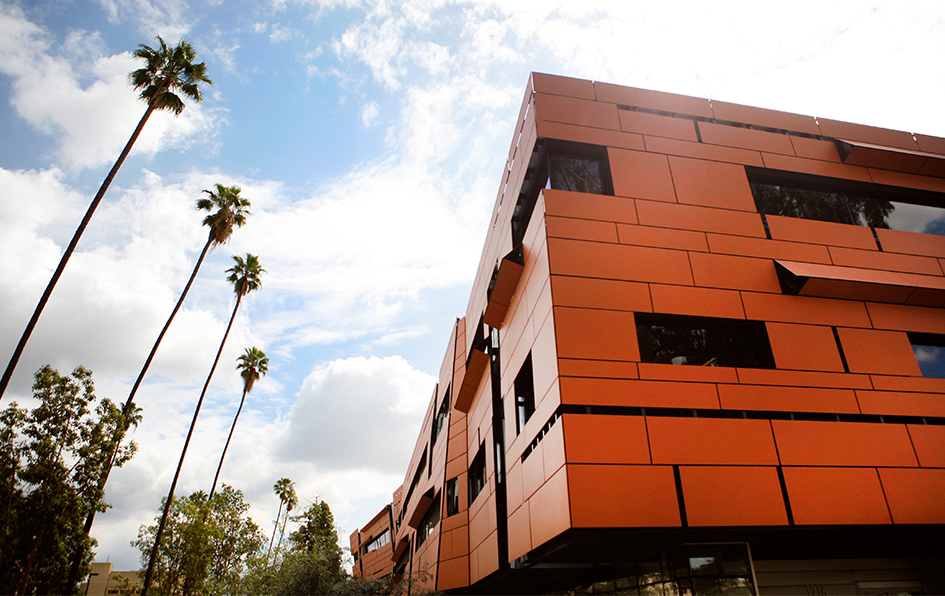

In [100]:
# Import image
#im = Image.open('dog.jpg')
im = Image.open('cahill.jpg')
#im = Image.open('Octocat.png')
width, height = im.size # (width, height) = (1240, 698)
print im.size
display(im)

im_edges = im.filter(ImageFilter.FIND_EDGES)
#display(im_edges)

# Apply gaussian filter from PIL package
im_gaus = im.filter(ImageFilter.GaussianBlur(radius=1))
#display(im_gaus)

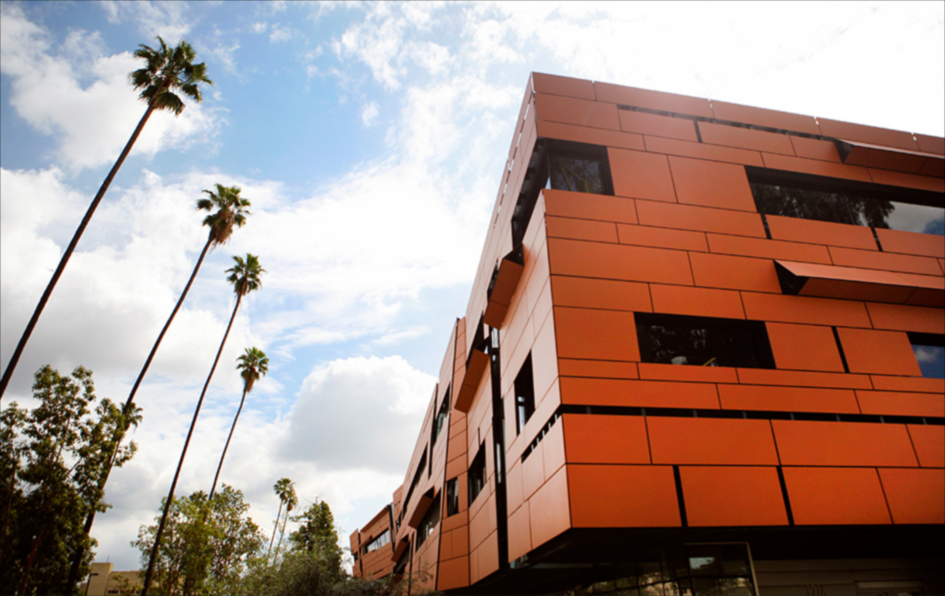

In [92]:
# Implement gaussian filter 
# pixel array is 3D: height x width x color
pixels = np.asarray(im)
color_no = np.size(pixels, 2)
#stencil5x5 = np.exp([[-8, -5, -4, -5, -8],[-5, -4, -1, -4, -5],[-4, -1, 0, -1, -4],[-5, -4, -1, -4, -5],[-8, -5, -4, -5, -8]])

# Generate NxN stencil
# Takes in an odd number and outputs a gaussian array
def stencil(N):
    A = np.ones((N,1))
    A_x = A * np.arange(-(N-1)/2, (N-1)/2 + 1)
    A_y = np.transpose(A_x)
    stencilNxN = np.exp(-A_x**2 - A_y**2)
    # Normalize stencil
    stencilNxN = stencilNxN / np.sum(stencilNxN)
    return stencilNxN

stencil9x9 = stencil(9)

# apply gaussian filter to pixels
def gaus_sum(i, j, k, padded_arr, stencil, d):
    sum_gaus = int(np.sum(padded_arr[i-d:i+d+1, j-d:j+d+1, k] * stencil))
    return sum_gaus
            
# Takes in pixel array and NxN gaussian stencil 
# returns filtered pixel array
def gaus_stencil(height, width, color_no, pixels, stencil):
    d = (np.size(stencil,0) - 1)/2
    padded_arr = np.zeros((height + 2*d, width + 2*d, np.size(pixels,2)))
    padded_arr[d:-d, d:-d,:] = pixels
    pixel_gaus = np.zeros((height, width, np.size(pixels,2)))
    for k in range(color_no):    
        for i in range(height):
            for j in range(width):
                pixel_gaus[i, j, k] = gaus_sum(i+d, j+d, k, padded_arr, stencil, d)
    return pixel_gaus
                
pixel_gaus = gaus_stencil(height, width, color_no, pixels, stencil9x9).astype(np.uint8)

im_gaus = Image.fromarray(pixel_gaus)
display(im_gaus)

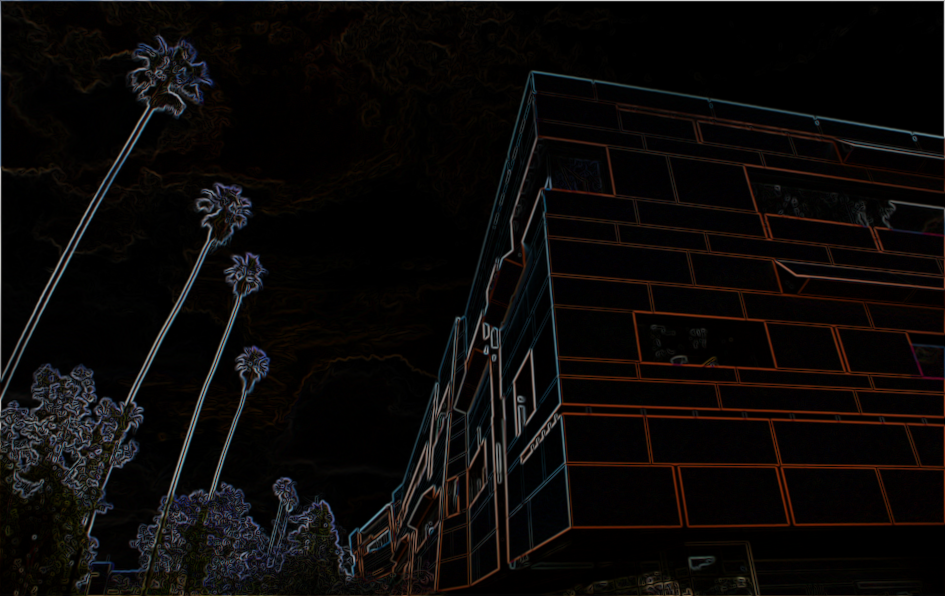

In [94]:
# Edge detection on slightly blurred image
# Find intensity of gradient
# use Sobel Method
# Takes in pixel array blurred by gaussian filter and returns 
# gradient and direction arrays
def Sobel(pixels_gaus, height, width, color_no):
    g_x = np.outer(np.array([1,2,1]), np.array([1,0,-1]))
    g_y = np.transpose(g_x)
    # normalize
    norm = np.sqrt(np.sum(g_x**2 + g_y**2))
    g_x = g_x/norm
    g_y = g_y/norm
    direction = np.zeros((height, width, color_no))
    gradient = np.zeros((height, width, color_no))
    padded_arr = np.zeros((height + 2, width + 2, color_no))
    padded_arr[1:-1, 1:-1,:] = pixels_gaus
    for k in range(color_no):    
        for i in range(height):
            for j in range(width):
                del_x = np.sum(padded_arr[i:i+3, j:j+3, k] * g_x)
                del_y = np.sum(padded_arr[i:i+3, j:j+3, k] * g_y)
                gradient[i, j, k] = int(np.sqrt(del_x**2 + del_y**2))
                direction[i, j, k] = np.arctan2(del_y, del_x)
    return gradient, direction
Sobel_tuple = Sobel(pixel_gaus, height, width, color_no)
gradient = Sobel_tuple[0].astype(np.uint8)
direction = Sobel_tuple[1]
display(Image.fromarray(gradient))

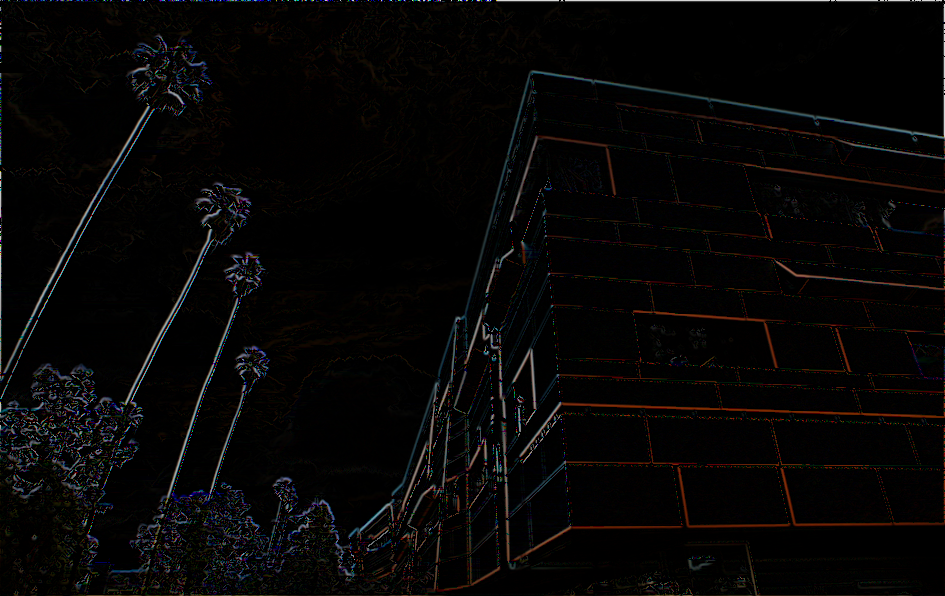

In [114]:
# Find intensity gradient
# Use derivative of gaussian
# Takes in pixel array blurred by gaussian filter and width of gaussian ditribution
# returns gradient and direction arrays
def gaussian_del(pixel_gaus, N, gaus_width, height, width, color_no):
    d = (N-1)/2
    A = np.ones((N,1))
    A_x = A * np.arange(-(N-1)/2, (N-1)/2 + 1)
    A_y = np.transpose(A_x)
    stencilNxN = np.exp(-(A_x**2 + A_y**2)/(2 * gaus_width**2))
    g_x = -A_x / gaus_width**2 * stencilNxN 
    g_y = -A_y / gaus_width**2 * stencilNxN
    # Normalize
    norm = np.sqrt(np.sum(g_x**2 + g_y**2))
    g_x = g_x/norm
    g_y = g_y/norm
    padded_arr = np.zeros((height + 2*d, width + 2*d, np.size(pixels,2)))
    padded_arr[d:-d, d:-d,:] = pixel_gaus
    gradient = np.zeros((height, width, color_no))
    direction = np.zeros((height, width, color_no))
    for k in range(color_no):
        for i in range(height):
            for j in range(width):
                del_x = np.sum(padded_arr[i:i+N, j:j+N, k] * g_x)
                del_y = np.sum(padded_arr[i:i+N, j:j+N, k] * g_y)
                gradient[i, j, k] = int(np.sqrt(del_x**2 + del_y**2))
                direction[i, j, k]= np.arctan2(del_y, del_x)
    return gradient, direction
gaus_grad = gaussian_del(pixel_gaus, 5, 0.7, height, width, color_no)
gaus_suppressed = non_max_suppression(gaus_grad[0], gaus_grad[1], height, width, color_no).astype(np.uint8)
display(Image.fromarray(gaus_suppressed))

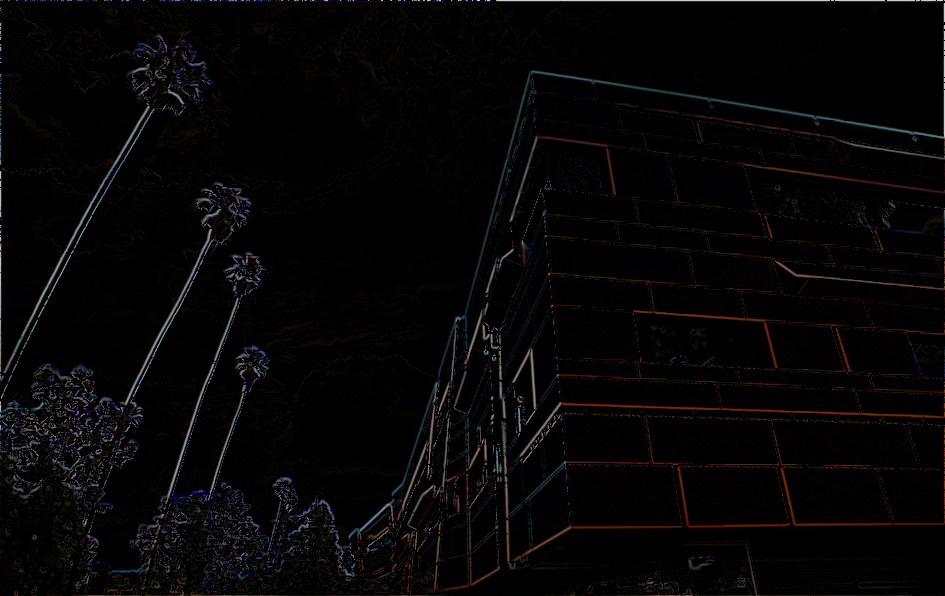

In [95]:
# Notice that the graph above has edges that are not of the same thickness
# We use non-maximum suppression to make the thicker edges thinner
# Non-maximum supression method
# Takes in gradient and direction matrices from intensity gradient methods and returns a pixel array
def non_max_suppression(gradient, direction, height, width, color_no):
    padded_arr = np.zeros((height + 2, width + 2, color_no))
    padded_arr.fill(0)
    padded_arr[1:-1, 1:-1,:] = gradient
    direction = direction * 180/np.pi
    direction[direction < 180] += 180
    a = 0
    b = 0
    for k in range(color_no):
        for i in range(1, height+1):
            for j in range(1, width+1):
                # x+1 and x-1
                if 0 <= direction[i-1, j-1, k] < 22.5 or 157.5 <= direction[i-1, j-1, k] <= 180:
                    a = padded_arr[i+1, j, k]
                    b = padded_arr[i-1, j, k]
                # x+1, y+1 and x-1, y-1
                elif 22.5 <= direction[i-1, j-1, k] < 67.5:
                    a = padded_arr[i+1, j+1, k]
                    b = padded_arr[i-1, j-1, k]
                # y+1 and y-1
                elif 67.5 <= direction[i-1, j-1, k] < 112.5:
                    a = padded_arr[i, j+1, k]
                    b = padded_arr[i, j-1, k]
                # x+1, y-1 and x-1, y+1
                elif 112.5 <= direction[i-1, j-1, k] < 157.5:
                    a = padded_arr[i+1, j-1, k]
                    b = padded_arr[i-1, j+1, k]
                if padded_arr[i, j, k] < a or padded_arr[i, j, k] < b:
                    gradient[i-1, j-1, k] = 0
    return gradient
gradient_suppressed = non_max_suppression(gradient, direction, height, width, color_no).astype(np.uint8)
display(Image.fromarray(gradient_suppressed))

In [12]:
N = 7
A=np.ones((N,1))
print A*np.arange(-(N-1)/2,N/2+1)
print np.transpose(A*np.arange(-(N-1)/2,N/2+1))
print((A*np.arange(-(N-1)/2,N/2+1))**2 + np.transpose(A*np.arange(-(N-1)/2,N/2+1))**2 )

[[-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]]
[[-3. -3. -3. -3. -3. -3. -3.]
 [-2. -2. -2. -2. -2. -2. -2.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.  3.  3.]]
[[18. 13. 10.  9. 10. 13. 18.]
 [13.  8.  5.  4.  5.  8. 13.]
 [10.  5.  2.  1.  2.  5. 10.]
 [ 9.  4.  1.  0.  1.  4.  9.]
 [10.  5.  2.  1.  2.  5. 10.]
 [13.  8.  5.  4.  5.  8. 13.]
 [18. 13. 10.  9. 10. 13. 18.]]


In [8]:
A = np.arange(-(N//2),N//2+1)
print(np.transpose(A[np.newaxis,:]))
np.reshape(A,(5,1))

[[-2]
 [-1]
 [ 0]
 [ 1]
 [ 2]]


array([[-2],
       [-1],
       [ 0],
       [ 1],
       [ 2]])